## Apple Stock Price and Sentiment Data Analysis

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [69]:
df = pd.read_csv("prices_and_sentiment_score.csv", index_col = 0)
df.head()

,Open,High,Low,Close,Adj Close,Volume,trading_time,score
Date,,,,,,,,
2014-01-28,18.170000,18.392857,17.931070,18.089287,16.087397,1.065523e+09,2014-01-28 09:30:00+00:00,0.039278
2014-01-29,17.998215,18.120358,17.807858,17.883928,15.904763,5.028100e+08,2014-01-29 09:30:00+00:00,0.026540
2014-01-30,17.947857,18.089287,17.739286,17.849285,15.873960,6.785016e+08,2014-01-30 09:30:00+00:00,0.029652
2014-01-31,17.684999,17.911785,17.626785,17.878571,15.900002,4.647972e+08,2014-01-31 09:30:00+00:00,0.213817
2014-02-03,17.950357,18.133215,17.832144,17.911785,15.929543,4.014640e+08,2014-02-03 09:30:00+00:00,-0.028657


positive_sentiment_count : 450 
negative_sentiment_count : 266 


<AxesSubplot:xlabel='Date'>

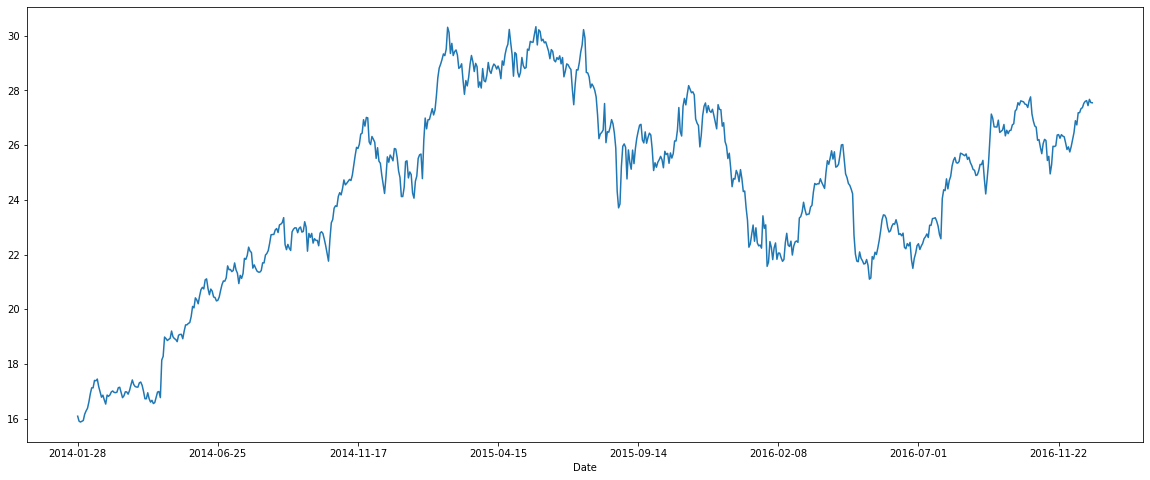

In [70]:
# Let's analyze how many negative and positive sentiments do we have, and how our apple stock is trending.

positive_sentiment_count = len(df[df['score'] > 0])
negative_sentiment_count = len(df[df["score"] < 0])

print("positive_sentiment_count : {} ".format(positive_sentiment_count))
print("negative_sentiment_count : {} ".format(negative_sentiment_count))

# Plot our apple prices
df["Adj Close"].plot(figsize=(20,8))

As we can see that we have more positive sentiment count (450) as compared to negative sentiment count (266), and we can see it's effect in out apple stock price, as we can see overall the trend is increasing. Its not incrementing sharply. It's like a mixture of positive (from 2014-01-28 to 2014-11-17), neutral (from 2014-11-17 to 2015-07), and decreasing (from 2015-07 to 2016-05), and then again positive(from 2016-05 to 2016-11). Overall it's a mixture of positive and neutral trend most of the time. Let's double check this with the probability distribution.

/Users/harsh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sentiment score probability distribution')

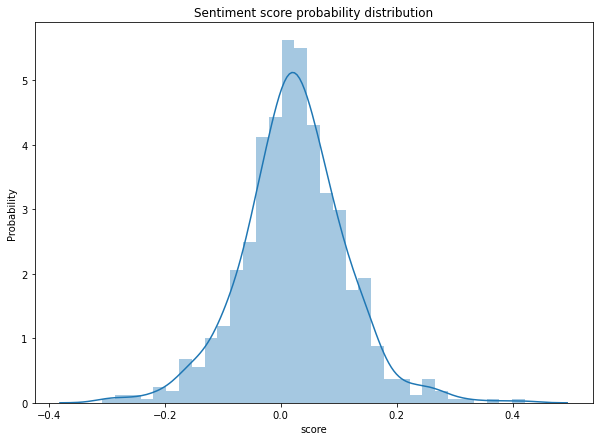

In [71]:

'''
The code contains the demonstration of probability distribution of sentiment score.
This was adapted from a medium post from Shagun Kala on 31/07/2021.

Medium Post here: 
https://medium.com/@kala.shagun/stock-market-prediction-using-news-sentiments-f9101e5ee1f4

'''

# Now let's test the proability distribution of the sentiment score that was calculated by VADER
plt.figure(figsize=(10, 7))
sns.distplot(df['score'])
plt.ylabel('Probability')
plt.title('Sentiment score probability distribution')

Here we can see the VADER is capturing the sentiment correctly which is quite a mixture of positive and neutral, as we can see it's slightly shifted towards right, but overall the sentiment is quite in an intersection of positive and neutral sentiment(we can confirm it from looking at the above price line plot).

## Modeling Apple Financial Time Series with Long Short-Term Memory and Sentiment Score

### Data Pre-processing

In [49]:
apple = pd.read_csv("prices_and_sentiment_score.csv")[["Date", "score", "Adj Close"]]
apple.head()

,Date,score,Adj Close
0,2014-01-28,0.039278,16.087397
1,2014-01-29,0.026540,15.904763
2,2014-01-30,0.029652,15.873960
3,2014-01-31,0.213817,15.900002
4,2014-02-03,-0.028657,15.929543


In [50]:
print(len(apple))

725


In [ ]:
'''
The code contains the demonstration of splitting the dataset into training, validation and test dataset.
This idea for split-ratio is adapted from a medium post from Shagun Kala on 31/07/2021.

Medium Post here: 
https://medium.com/@kala.shagun/stock-market-prediction-using-news-sentiments-f9101e5ee1f4

'''

In [56]:
#Splitting the dataset into training, validation, and testing dataset
#Train ratio = 64 %
#Validation ratio = 16%
#Test ratio = 20%

train_apple = apple[0:int(len(apple)*0.8)]
X_train_apple, X_validate_apple, test_apple = np.split(apple, [int(0.64 * len(apple)), int(0.8 * len(apple))])

# Setting Date column as an index, this will help to perform data visualization with x-axis as a Date column
train_apple = train_apple.set_index('Date', drop= False)
X_train_apple = X_train_apple.set_index('Date', drop= False)
X_validate_apple = X_validate_apple.set_index('Date', drop= False)
test_apple = test_apple.set_index('Date', drop= False)


print(len(X_train_apple), len(X_validate_apple), len(test_apple))

464 116 145


### Feature Scaling and Data Preparation

In [ ]:
'''
The code contains Feature scaling.
This was adapted from a medium post from Shagun Kala on 31/07/2021.

Medium Post here: 
https://medium.com/@kala.shagun/stock-market-prediction-using-news-sentiments-dc4c24c976f7

'''

In [52]:
# Feature Scaling: We need data to be scaled as gradient descent based optimization algorithm requires it.
from sklearn.preprocessing import MinMaxScaler

# Feature scaling for apple stock closing price
stock_price_scaling_object = MinMaxScaler()

closing_price_train = X_train_apple['Adj Close'].values.reshape(-1, 1)
closing_price_validate = X_validate_apple['Adj Close'].values.reshape(-1, 1)
closing_price_test = test_apple['Adj Close'].values.reshape(-1, 1)

minmax_scaled_training_stock_price_data = stock_price_scaling_object.fit_transform(closing_price_train)
minmax_scaled_validation_stock_price_data = stock_price_scaling_object.transform(closing_price_validate)
minmax_scaled_test_stock_price_data = stock_price_scaling_object.transform(closing_price_test)

# Feature scaling for apple stock sentiment score
sentiment_score_scaling_object = MinMaxScaler()

sentiment_score_train = X_train_apple['score'].values.reshape(-1, 1)
sentiment_score_validate = X_validate_apple['score'].values.reshape(-1, 1)
sentiment_score_test = test_apple['score'].values.reshape(-1, 1)

minmax_scaled_training_sentiment_score_data = sentiment_score_scaling_object.fit_transform(sentiment_score_train)
minmax_scaled_validation_sentiment_score_data = sentiment_score_scaling_object.transform(sentiment_score_validate)
minmax_scaled_test_sentiment_score_data = sentiment_score_scaling_object.transform(sentiment_score_test)

In [53]:
# Preparing the dataset for training the model

# This is like a regression task, so we need two datasets the input (X) and the output(Y)


# The sequential relationship is maintained in the datasets, because we are currently exploiting the sequential model.
def data_preparation(stockPrice, sentimentScore, sequenceLength):
    
    # X is acting like an input feature vectors (combination of stock price + sentiment score of last day).
    # Y is acting like a vector of corresponding target (last day stock price) values.
    X, Y = [], []
    for i in range(len(stockPrice)-sequenceLength-1):
        
        # iteratively extracting the look back sequence length of stock price data. Here sequenceLength = 40
        stock_price = stockPrice[i:(i+sequenceLength), 0]
        
        # iteratively extracting the sentment score of last day
        sentiment_score = sentimentScore[i+sequenceLength-1]
        
        # X is a combination of the stock price of previous 40 days and sentiment score of the last day
        X.append(np.append(stock_price,sentiment_score))
        
        # Y is the stock price of the last day. This next value will be treated as the target
        Y.append(stockPrice[i + sequenceLength, 0])
        
    return np.array(X), np.array(Y)


train_input_featureX, train_targetY = data_preparation(minmax_scaled_training_stock_price_data, 
                                                       minmax_scaled_training_sentiment_score_data, 
                                                       40)

validation_input_featureX, validation_targetY = data_preparation(minmax_scaled_validation_stock_price_data, 
                                                                 minmax_scaled_validation_sentiment_score_data, 
                                                                 40)

test_input_featureX, test_targetY = data_preparation(minmax_scaled_test_stock_price_data, 
                                                     minmax_scaled_test_sentiment_score_data, 
                                                     40)




In [54]:
# Here, For example, train_input_featureX has 423 sequences and each sequences have total 41 time-steps.
# After this, we will transform these matrices into different batches by reshaping them so that 
# they get accepted by our recurrent neural network.

train_input_featureX.shape, validation_input_featureX.shape, test_input_featureX.shape

((423, 41), (75, 41), (104, 41))

In [55]:
#Converting the above prepared datasets into 3-dimentional tensor to handle the batch gradient descent.

train_input_featureX, train_targetY = np.array(train_input_featureX), np.array(train_targetY)
train_input_featureX = np.reshape(train_input_featureX, 
                                  (train_input_featureX.shape[0], train_input_featureX.shape[1], 1))

validation_input_featureX, validation_targetY = np.array(validation_input_featureX), np.array(validation_targetY)
validation_input_featureX = np.reshape(validation_input_featureX, 
                                       (validation_input_featureX.shape[0], validation_input_featureX.shape[1], 1))

test_input_featureX, test_targetY = np.array(test_input_featureX), np.array(test_targetY)
test_input_featureX = np.reshape(test_input_featureX, 
                                 (test_input_featureX.shape[0], test_input_featureX.shape[1], 1))

train_input_featureX.shape, validation_input_featureX.shape, test_input_featureX.shape

((423, 41, 1), (75, 41, 1), (104, 41, 1))

### Apple Stock Price Prediction with sentiment data using LSTM RNN Model

In [ ]:
'''
The code contains RNN modeling using keras library and data visualization of the dataset.
This was adapted from a medium post from Shagun Kala on 31/07/2021.

Medium Post here: 
https://medium.com/@kala.shagun/stock-market-prediction-using-news-sentiments-dc4c24c976f7

'''

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend


# Defining the sequential model
model = Sequential()

# Adding LSTM layer with 128 units, hyperbolic tangent as an activation function,
# and input shape in case of train_input_featureX will be (100, 1)
model.add(LSTM(units=128, activation='tanh', 
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), 
               input_shape = (train_input_featureX.shape[1], 1), 
               unroll = True))

# After setting the recurrent layer, now adding the output layer
model.add(Dense(1, name="output_layer"))


#Defining our loss function
def root_mean_squared_error(y_true, y_pred):
    
    error = y_pred - y_true
    squared_error = backend.square(error)
    mean_squared_error = backend.mean(squared_error)
    square_root_of_mean_squared_error = backend.sqrt(mean_squared_error)
    return square_root_of_mean_squared_error

# RNN model compiling
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), 
              loss = root_mean_squared_error)



# Fitting the RNN model to the Training set
model.fit(train_input_featureX, train_targetY, 
          epochs = 50, 
          batch_size = 16,  
          validation_data = (validation_input_featureX, validation_targetY))




The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50
27/27 [==============================] - 5s 57ms/step - loss: 0.2154 - val_loss: 0.0479
Epoch 2/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0601 - val_loss: 0.0493
Epoch 3/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0423 - val_loss: 0.0346
Epoch 4/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0409 - val_loss: 0.0341
Epoch 5/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0360 - val_loss: 0.0299
Epoch 6/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0371 - val_loss: 0.0285
Epoch 7/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0323 - val_loss: 0.0329
Epoch 8/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0359 - val_loss: 0.0348
Epoch 9/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0326 - val_loss: 0.0284
Epoch 10/50
27/27 [

In [86]:
#Predicting on test data

predicted_stock_price = model.predict(test_input_featureX)
predicted_stock_price = stock_price_scaling_object.inverse_transform(predicted_stock_price)

In [87]:
#Changing datatype of date column from string to datetime

import datetime as dt
train_apple['Date'] = pd.to_datetime(train_apple['Date'])
test_apple['Date'] = pd.to_datetime(test_apple['Date'])

train_apple['Date'] = train_apple['Date'].dt.date
test_apple['Date'] = test_apple['Date'].dt.date

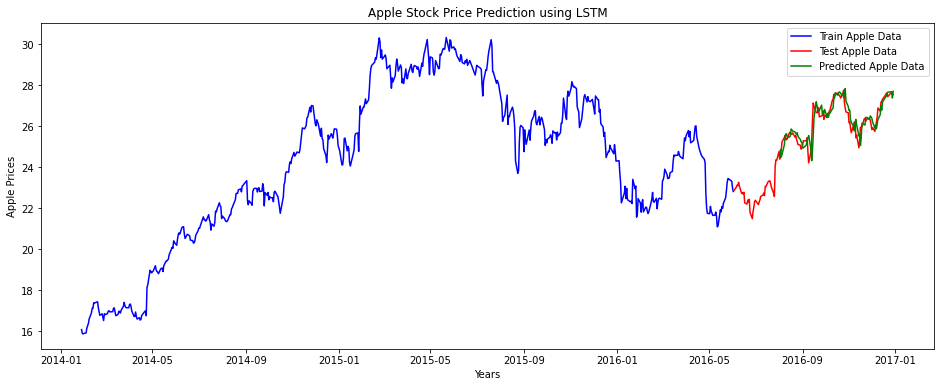

RMSE_LSTM = 0.43


In [89]:
# Visualising our prediction model results

import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(16, 6))
plt.plot(train_apple['Date'], train_apple['Adj Close'], color = 'blue', label = 'Train Apple Data')
plt.plot(test_apple['Date'], test_apple['Adj Close'].values, color = 'red', label = 'Test Apple Data')
plt.plot(test_apple.iloc[41:]['Date'], predicted_stock_price, color = 'green', label = 'Predicted Apple Data')
plt.title('Apple Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('Apple Prices')
plt.legend()
plt.show()



RMSE_LSTM = sqrt(mean_squared_error(test_apple.iloc[41:]['Adj Close'].values, predicted_stock_price))

print(f"RMSE_LSTM = {round(RMSE_LSTM,2)}")

RMSE has reduced to 0.43 from 0.48. News Sentiments has helped LSTM to improve the prediction further. This Model takes stock price data of last 40 days along with News Sentiment Compound Score from VADER for the last day and it will predict the stock price for next day.


In [ ]:
# Experiment

# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))